# Modeling


<span style="font-size: 14px;">Based on the findings in the Exploratory Data Analysis (EDA) section, in this section will apply <span style="font-size: 14px;">the following models to both the original and transformed datasets:

###### Logistic Regression: 
<span style="font-size: 14px;">A widely used model for binary classification tasks. We will evaluate its performance on both the <span style="font-size: 14px;">original and transformed data to understand its ability to predict outcomes.

###### Decision Tree: 
<span style="font-size: 14px;">A flexible model that works well for both classification and regression tasks. We will use this <span style="font-size: 14px;">model to see how it performs with both the original and transformed data, especially in handling <span style="font-size: 14px;">categorical variables.

###### Neural Network: 
<span style="font-size: 14px;">A powerful model for complex datasets, especially when there are non-linear relationships. We <span style="font-size: 14px;">will apply this model to both the original and transformed data to assess its performance in <span style="font-size: 14px;">capturing intricate patterns in the data.


<span style="font-size: 14px;">The transformation will be applied using the methods considered most effective; Yeo-Johnson and <span style="font-size: 14px;">Square-Root transformations.

<span style="font-size: 14px;">At the end the performance of these models will be evaluated using appropriate metrics (Accuracy <span style="font-size: 14px;">and ROC-AUC) to determine the best-performing model for the given problem.

# Required Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Load Data

- To review the dataset and explore its descriptive statistics, please click on the **EDA** section.


[EDA Section](http://localhost:8888/notebooks/OneDrive/Desktop/Hospital%20Readmission/Hospital-Readmission-/00%20-%20eda.ipynb)


In [2]:
data=pd.read_csv("Data/hospital_readmissions.csv")
print(f"\033[1mDataset Shape:\033[0m {data.shape}")



Dataset Shape: (25000, 17)


# Data Transformation


In [3]:

# Identify numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Log Transformation (only for positive values)
data_log = data[numerical_columns].apply(lambda x: np.log1p(x) if (x > 0).all() else x)

# Square Root Transformation (non-negative values)
data_sqrt = data[numerical_columns].apply(lambda x: np.sqrt(x) if (x >= 0).all() else x)

# Box-Cox or Yeo-Johnson Transformation
pt = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' if all values are positive
data_transformed = pd.DataFrame(
    pt.fit_transform(data[numerical_columns]),
    columns=numerical_columns
)

# Min-Max Scaling
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[numerical_columns]), columns=numerical_columns)

# Standardization (Z-Score)
scaler_standard = StandardScaler()
data_standardized = pd.DataFrame(scaler_standard.fit_transform(data[numerical_columns]), columns=numerical_columns)

# Add the transformed data to the original DataFrame or create new columns
data[numerical_columns + '_log'] = data_log
# Add square root-transformed columns
data[numerical_columns + '_sqrt'] = data_sqrt

# Add Yeo-Johnson transformed columns
data[numerical_columns + '_yeoj'] = data_transformed

# Add Min-Max scaled columns
data[numerical_columns + '_scaled'] = data_scaled

# Add Standardized columns
data[numerical_columns + '_standardized'] = data_standardized

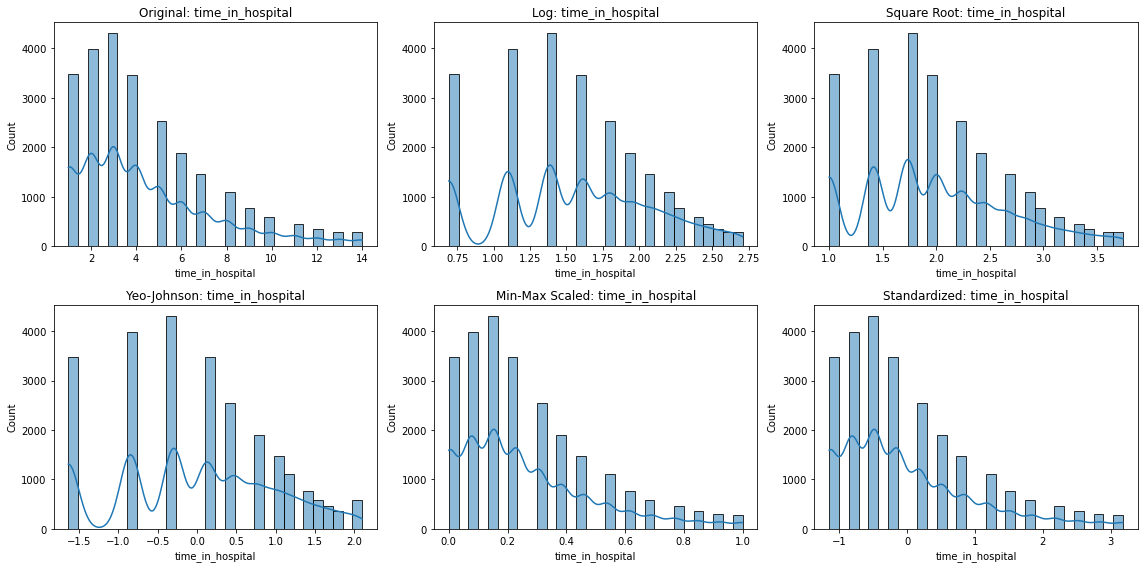

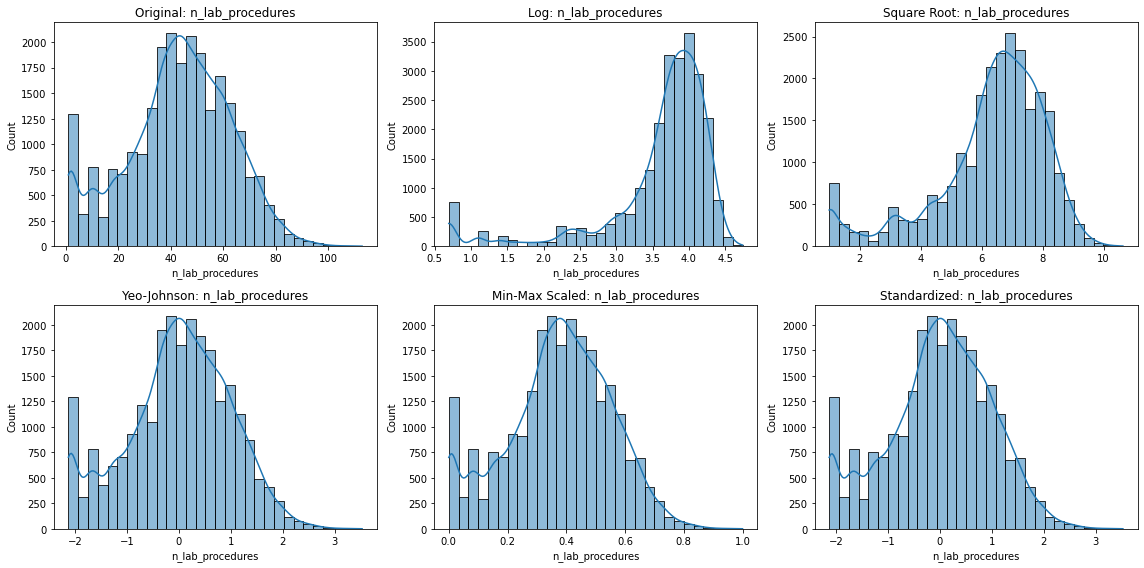

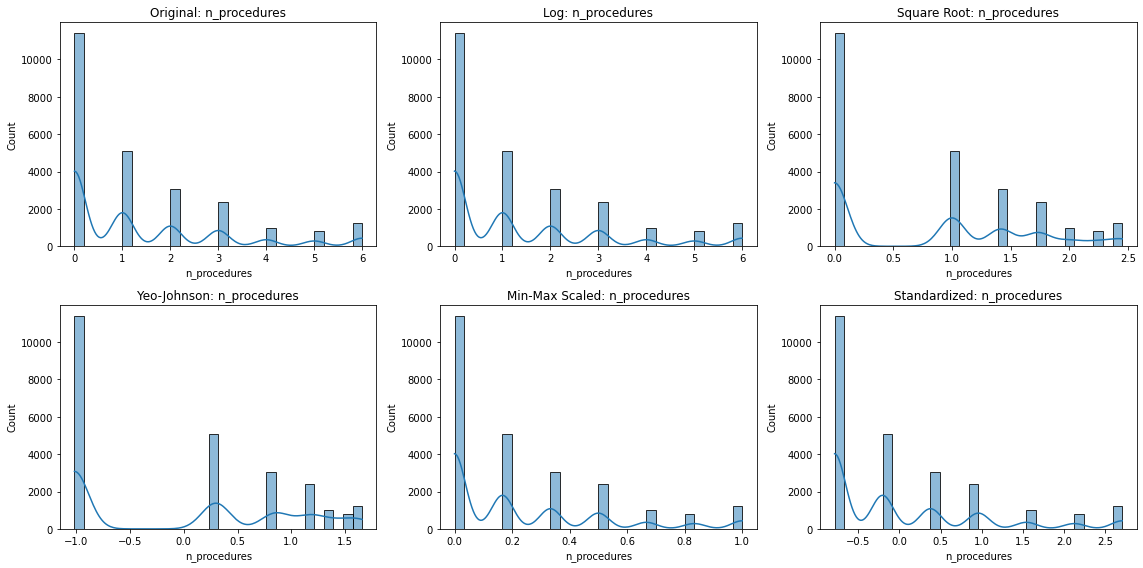

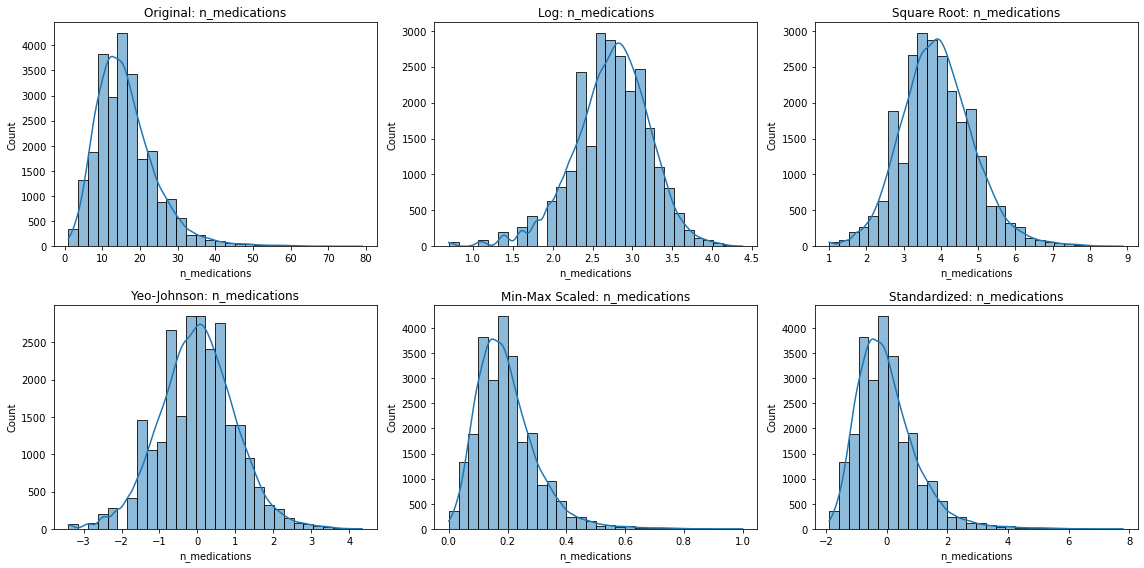

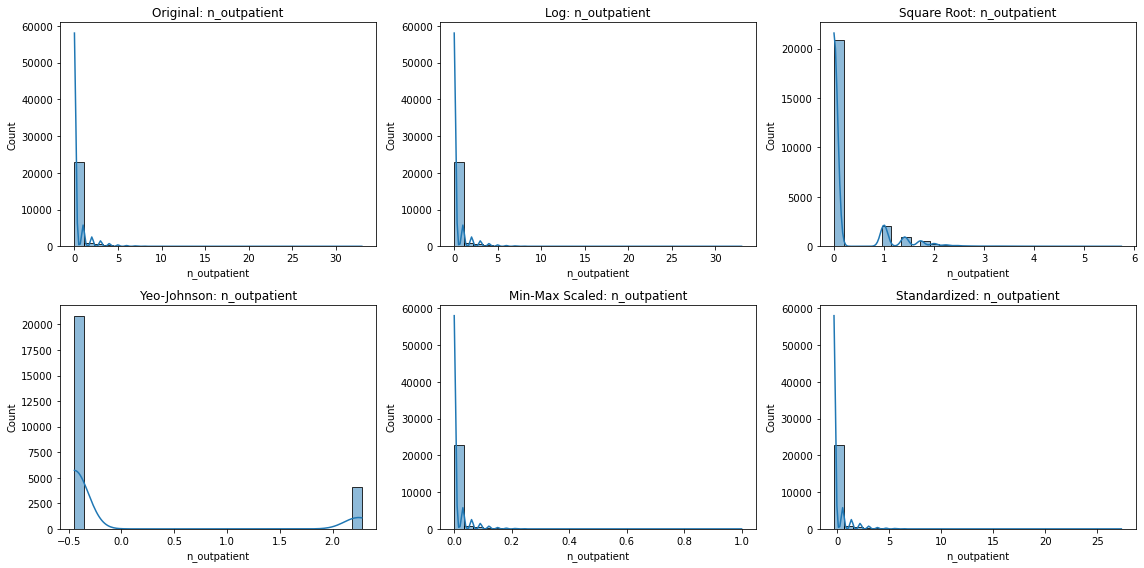

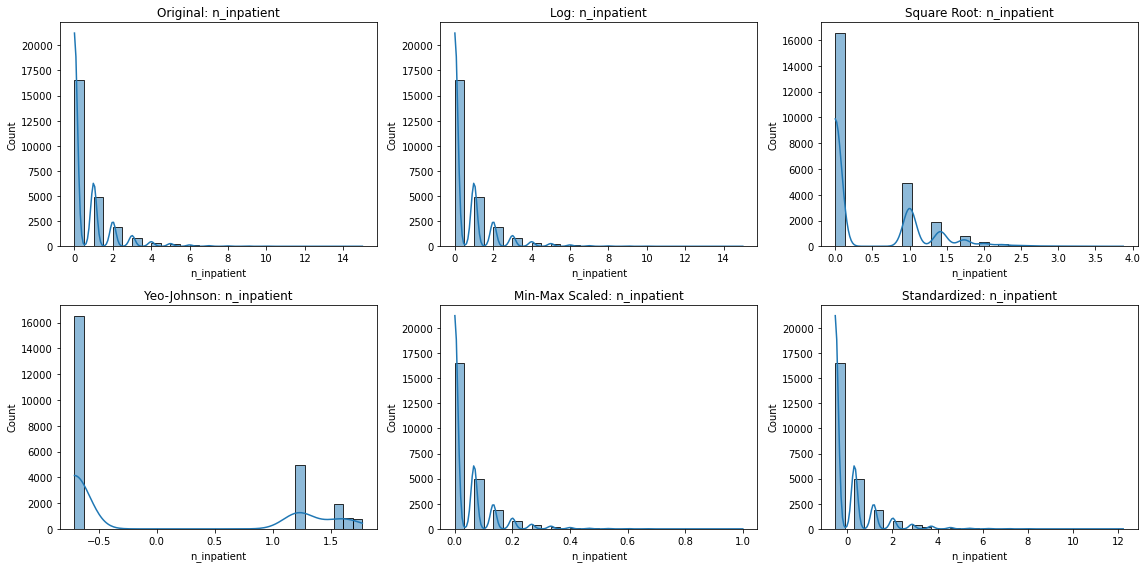

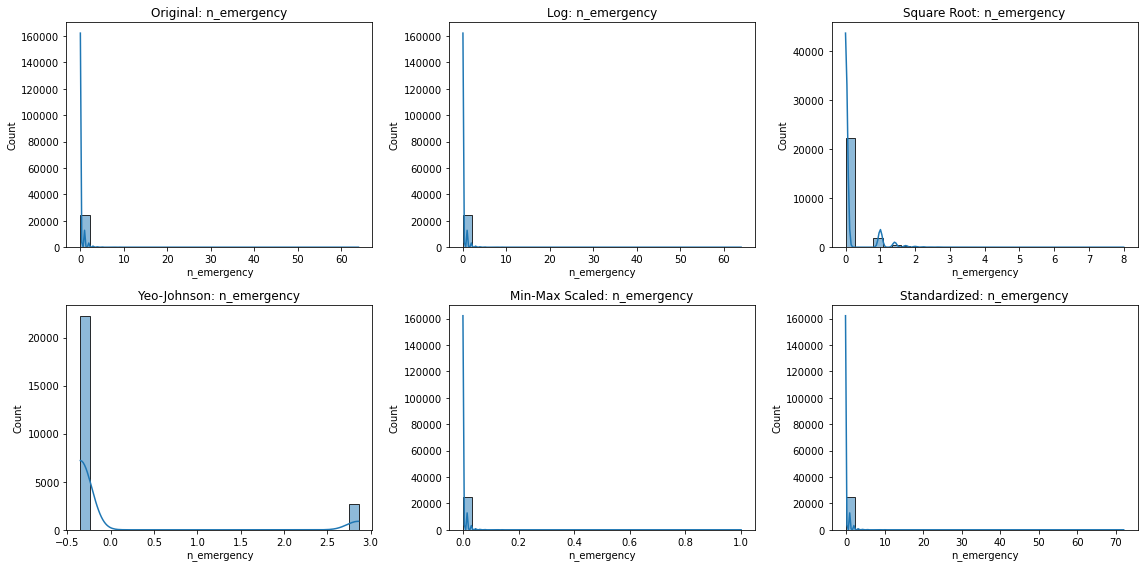

In [4]:


# List of transformed datasets
transformed_datasets = {
    'Log': data_log,
    'Square Root': data_sqrt,
    'Yeo-Johnson': data_transformed,
    'Min-Max Scaled': data_scaled,
    'Standardized': data_standardized
}

# Example: Plot histograms for original and each transformed dataset
for col in numerical_columns:
    plt.figure(figsize=(16, 8))
    
    # Plot original data
    plt.subplot(2, 3, 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Original: {col}')
    
    # Plot each transformed data
    for i, (transformation, transformed_data) in enumerate(transformed_datasets.items(), 2):
        plt.subplot(2, 3, i)
        sns.histplot(transformed_data[col], kde=True, bins=30)
        plt.title(f'{transformation}: {col}')
    
    plt.tight_layout()
    plt.show()

<Figure size 1008x576 with 0 Axes>

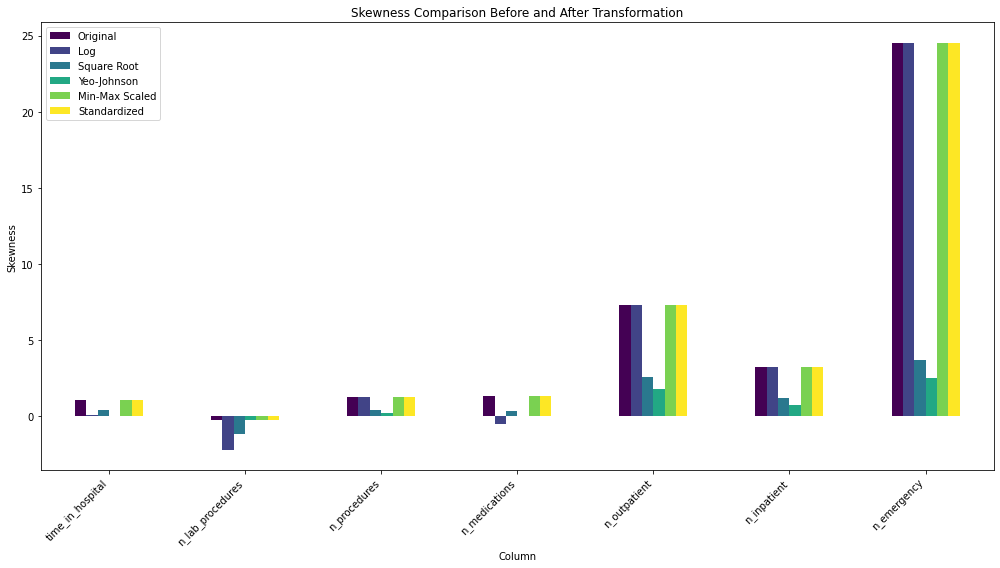

In [5]:


# Calculate Skewness for each transformation (including original)
skewness_original = data[numerical_columns].skew()
skewness_transformed = {
    'Log': data_log.skew(),
    'Square Root': data_sqrt.skew(),
    'Yeo-Johnson': data_transformed.skew(),
    'Min-Max Scaled': data_scaled.skew(),
    'Standardized': data_standardized.skew()
}

# Collect skewness data into a DataFrame for visualization
skewness_df = pd.DataFrame({
    'Column': numerical_columns,
    'Original': skewness_original,
    'Log': skewness_transformed['Log'],
    'Square Root': skewness_transformed['Square Root'],
    'Yeo-Johnson': skewness_transformed['Yeo-Johnson'],
    'Min-Max Scaled': skewness_transformed['Min-Max Scaled'],
    'Standardized': skewness_transformed['Standardized']
})

# Plot Skewness comparison
plt.figure(figsize=(14, 8))
skewness_df.set_index('Column').plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Skewness Comparison Before and After Transformation')
plt.ylabel('Skewness')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





<span style="font-size: 14px;">Based on the different methods of transformation, Yeo-Johnson and Square Root methods, impacted the skewness in the numerical variables.
<span style="font-size: 14px;">Here, Decision Tree Model, Neural Network and Logistic Regression models will be applied using the Original data, transformed data using Yeo-Johnson 
<span style="font-size: 14px;">and Square Root methods. 

### Logistic Regression Model

In [6]:



# Function to apply square root transformation
def square_root_transformation(X):
    return np.sqrt(X)

# Function to apply Yeo-Johnson transformation
def yeo_johnson_transformation(X):
    pt = PowerTransformer(method='yeo-johnson')
    return pt.fit_transform(X)

# Define the transformations for different pipelines
transformers = {
    'Original': FunctionTransformer(),
    'Square Root': FunctionTransformer(square_root_transformation),
    'Yeo-Johnson': FunctionTransformer(yeo_johnson_transformation)
}

# Split the data into features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Handle categorical data by encoding them
categorical_columns = X.select_dtypes(include=['object']).columns
X[categorical_columns] = X[categorical_columns].apply(LabelEncoder().fit_transform)

# Store results
results_LogisticRegression = {}

# Iterate over transformations
for transformation_name, transformer in transformers.items():
    print(f"Building pipeline for: {transformation_name}")
    
    # Preprocessing pipeline
    pipeline = Pipeline([
        ('preprocessing', ColumnTransformer([
            ('numerical', transformer, X.columns)  # Apply transformation to all features
        ], remainder='passthrough')),
        
        ('imputer', SimpleImputer(strategy='mean')),  # Handling missing values, if any
        ('scaler', StandardScaler()),  # Scaling the data before logistic regression
        ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression model
    ])
    
    # 2. Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Fit the model
    pipeline.fit(X_train, y_train)

    # 4. Make predictions
    y_pred = pipeline.predict(X_test)

    # 5. Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])  # For ROC-AUC

    # Store the results
    results_LogisticRegression[transformation_name] = {
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report,
        'roc_auc': roc_auc
    }

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc:.4f}\n")

# Final summary of results
print("Comparison of the Results using Logistic Regression:")
for name, result in results_LogisticRegression.items():
    print(f"Model: {name}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  ROC-AUC: {result['roc_auc']:.4f}")
    print("-" * 40)


Building pipeline for: Original
Accuracy: 0.6122
Confusion Matrix:
[[2007  651]
 [1288 1054]]
Classification Report:
              precision    recall  f1-score   support

          no       0.61      0.76      0.67      2658
         yes       0.62      0.45      0.52      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.60      5000
weighted avg       0.61      0.61      0.60      5000

ROC-AUC: 0.6489

Building pipeline for: Square Root
Accuracy: 0.6152
Confusion Matrix:
[[2014  644]
 [1280 1062]]
Classification Report:
              precision    recall  f1-score   support

          no       0.61      0.76      0.68      2658
         yes       0.62      0.45      0.52      2342

    accuracy                           0.62      5000
   macro avg       0.62      0.61      0.60      5000
weighted avg       0.62      0.62      0.61      5000

ROC-AUC: 0.6462

Building pipeline for: Yeo-Johnson
Accuracy: 0.6082
Confusion Matrix:
[[199

<span style="font-size: 14px;">The ROC-AUC also shows only minor variations between the models. The original model has the highest ROC-AUC (0.6489), 
<span style="font-size: 14px;">followed by the square root model (0.6462), and the Yeo-Johnson transformation (0.6455). 
<span style="font-size: 14px;">This suggests that the transformations are slightly decreasing the model’s ability to distinguish between the classes, 
<span style="font-size: 14px;">though the differences are small.


<span style="font-size: 14px;">The accuracy across the three transformations is very similar, with the square root transformation performing marginally 
<span style="font-size: 14px;">better than the original and Yeo-Johnson models. However, the differences are small (around 0.3% between the original 
<span style="font-size: 14px;"> and square root model), suggesting that the transformation does not dramatically change the model’s predictive power 
<span style="font-size: 14px;">in terms of accuracy.
    
    
<span style="font-size: 14px;">The Square Root Transformation provides the best performance in terms of accuracy and ROC-<span style="font-size: 14px;"> AUC, though the improvement is modest.
<span style="font-size: 14px;">The Original Model performs similarly in terms of both metrics and is a competitive baseline.
<span style="font-size: 14px;">The Yeo-Johnson Transformation provides slightly lower performance compared to both the original <span style="font-size: 14px;">and square root models, both in terms of accuracy and ROC-AUC.

In [7]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Function to apply square root transformation
def square_root_transformation(X):
    return np.sqrt(X)

# Function to apply Yeo-Johnson transformation
def yeo_johnson_transformation(X):
    pt = PowerTransformer(method='yeo-johnson')
    return pt.fit_transform(X)

# Define the transformations for different pipelines
transformers = {
    'Original': FunctionTransformer(),
    'Square Root': FunctionTransformer(square_root_transformation),
    'Yeo-Johnson': FunctionTransformer(yeo_johnson_transformation)
}

# Split the data into features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Handle categorical data by encoding them
categorical_columns = X.select_dtypes(include=['object']).columns
X[categorical_columns] = X[categorical_columns].apply(LabelEncoder().fit_transform)

# Store results
results_DecsionTree = {}

# Iterate over transformations
for transformation_name, transformer in transformers.items():
    print(f"Building pipeline for: {transformation_name}")
    
    # Preprocessing pipeline
    pipeline = Pipeline([
        ('preprocessing', ColumnTransformer([
            ('numerical', transformer, X.columns)  # Apply transformation to all features
        ], remainder='passthrough')),
        
        ('imputer', SimpleImputer(strategy='mean')),  # Handling missing values, if any
        ('scaler', StandardScaler()),  # Scaling the data before decision tree
        ('classifier', DecisionTreeClassifier(random_state=42))  # Decision Tree model
    ])
    
    # 2. Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Fit the model
    pipeline.fit(X_train, y_train)

    # 4. Make predictions
    y_pred = pipeline.predict(X_test)

    # 5. Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])  # For ROC-AUC

    # Store the results
    results_DecsionTree[transformation_name] = {
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report,
        'roc_auc': roc_auc
    }

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc:.4f}\n")

# Final summary of results
print("Comparison of the Results using DecisionTree:")
for name, result in results_DecsionTree.items():
    print(f"Model: {name}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  ROC-AUC: {result['roc_auc']:.4f}")
    print("-" * 40)


Building pipeline for: Original
Accuracy: 0.5418
Confusion Matrix:
[[1506 1152]
 [1139 1203]]
Classification Report:
              precision    recall  f1-score   support

          no       0.57      0.57      0.57      2658
         yes       0.51      0.51      0.51      2342

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.54      0.54      0.54      5000

ROC-AUC: 0.5401

Building pipeline for: Square Root
Accuracy: 0.5402
Confusion Matrix:
[[1502 1156]
 [1143 1199]]
Classification Report:
              precision    recall  f1-score   support

          no       0.57      0.57      0.57      2658
         yes       0.51      0.51      0.51      2342

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.54      0.54      0.54      5000

ROC-AUC: 0.5385

Building pipeline for: Yeo-Johnson
Accuracy: 0.5500
Confusion Matrix:
[[150

<span style="font-size: 14px;">The Yeo-Johnson Transformation provides the best performance, slightly improving both accuracy <span style="font-size: 14px;">and ROC-AUC over the original and square root models.
<span style="font-size: 14px;">The Square Root Transformation has a negligible effect on both accuracy and ROC-AUC compared to <span style="font-size: 14px;">the original model.
<span style="font-size: 14px;">Overall, the performance of the DecisionTree model is modest, with the best results achieved <span style="font-size: 14px;">using the Yeo-Johnson transformation.

In [8]:
# Import necessary libraries for Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Function to apply square root transformation
def square_root_transformation(X):
    return np.sqrt(X)

# Function to apply Yeo-Johnson transformation
def yeo_johnson_transformation(X):
    pt = PowerTransformer(method='yeo-johnson')
    return pt.fit_transform(X)

# Define the transformations for different pipelines
transformers = {
    'Original': FunctionTransformer(),
    'Square Root': FunctionTransformer(square_root_transformation),
    'Yeo-Johnson': FunctionTransformer(yeo_johnson_transformation)
}

# Split the data into features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Handle categorical data by encoding them
categorical_columns = X.select_dtypes(include=['object']).columns
X[categorical_columns] = X[categorical_columns].apply(LabelEncoder().fit_transform)

# Store results
results_NeuralNetwork = {}

# Iterate over transformations
for transformation_name, transformer in transformers.items():
    print(f"Building pipeline for: {transformation_name}")
    
    # Preprocessing pipeline
    pipeline = Pipeline([
        ('preprocessing', ColumnTransformer([
            ('numerical', transformer, X.columns)  # Apply transformation to all features
        ], remainder='passthrough')),
        
        ('imputer', SimpleImputer(strategy='mean')),  # Handling missing values, if any
        ('scaler', StandardScaler()),  # Scaling the data before neural network
        ('classifier', MLPClassifier(random_state=42, max_iter=500))  # Neural Network model (MLP)
    ])
    
    # 2. Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Fit the model
    pipeline.fit(X_train, y_train)

    # 4. Make predictions
    y_pred = pipeline.predict(X_test)

    # 5. Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])  # For ROC-AUC

    # Store the results
    results_NeuralNetwork[transformation_name] = {
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report,
        'roc_auc': roc_auc
    }

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc:.4f}\n")

# Final summary of results
print("Comparison of Results using Neural Network Model:")
for name, result in results_NeuralNetwork.items():
    print(f"Model: {name}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  ROC-AUC: {result['roc_auc']:.4f}")
    print("-" * 40)


Building pipeline for: Original
Accuracy: 0.5792
Confusion Matrix:
[[1711  947]
 [1157 1185]]
Classification Report:
              precision    recall  f1-score   support

          no       0.60      0.64      0.62      2658
         yes       0.56      0.51      0.53      2342

    accuracy                           0.58      5000
   macro avg       0.58      0.57      0.57      5000
weighted avg       0.58      0.58      0.58      5000

ROC-AUC: 0.6018

Building pipeline for: Square Root
Accuracy: 0.5722
Confusion Matrix:
[[1662  996]
 [1143 1199]]
Classification Report:
              precision    recall  f1-score   support

          no       0.59      0.63      0.61      2658
         yes       0.55      0.51      0.53      2342

    accuracy                           0.57      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.57      0.57      5000

ROC-AUC: 0.5991

Building pipeline for: Yeo-Johnson
Accuracy: 0.5848
Confusion Matrix:
[[159

<span style="font-size: 14px;">The Yeo-Johnson transformation provides the most significant improvement, 
<span style="font-size: 14px;">both in terms of accuracy and ROC-AUC, suggesting that this transformation has a positive impact on 
<span style="font-size: 14px;">the Neural Network model's performance.
<span style="font-size: 14px;">The Square Root transformation results in slightly worse performance across both metrics,
<span style="font-size: 14px;">indicating that it does not improve the model’s predictive power.
<span style="font-size: 14px;">The Original model performs well, but the Yeo-Johnson transformation clearly outperforms it.
<span style="font-size: 14px;">In summary, the Yeo-Johnson transformation is the most beneficial for improving both accuracy
<span style="font-size: 14px;">and ROC-AUC in the Neural Network model, while the Square Root transformation has a slight negative impact.

In [9]:
# Final summary of results - dynamically generated for all models
print("Comparison of the Results:")
BOLD = '\033[1m'
RESET = '\033[0m'
# Combine all the result dictionaries into one (this assumes you want to print all results)
all_results = {
    'Neural Network': results_NeuralNetwork,
    'Decision Tree': results_DecsionTree,
    'Logistic Regression': results_LogisticRegression
}

# Iterate over each model's results in the all_results dictionary
for model_name, results in all_results.items():
    print(f"{BOLD} *** Results for {model_name} ***:{RESET}")
    
    # Iterate over each transformation in the model's results
    for transformation_name, result in results.items():
        print(f"  Transformation: {transformation_name}")
        print(f"    Accuracy: {result['accuracy']:.4f}")
        print(f"    ROC-AUC: {result['roc_auc']:.4f}")
        print("-" * 40)


Comparison of the Results:
 *** Results for Neural Network ***:
  Transformation: Original
    Accuracy: 0.5792
    ROC-AUC: 0.6018
----------------------------------------
  Transformation: Square Root
    Accuracy: 0.5722
    ROC-AUC: 0.5991
----------------------------------------
  Transformation: Yeo-Johnson
    Accuracy: 0.5848
    ROC-AUC: 0.6188
----------------------------------------
 *** Results for Decision Tree ***:
  Transformation: Original
    Accuracy: 0.5418
    ROC-AUC: 0.5401
----------------------------------------
  Transformation: Square Root
    Accuracy: 0.5402
    ROC-AUC: 0.5385
----------------------------------------
  Transformation: Yeo-Johnson
    Accuracy: 0.5500
    ROC-AUC: 0.5490
----------------------------------------
 *** Results for Logistic Regression ***:
  Transformation: Original
    Accuracy: 0.6122
    ROC-AUC: 0.6489
----------------------------------------
  Transformation: Square Root
    Accuracy: 0.6152
    ROC-AUC: 0.6462
------------

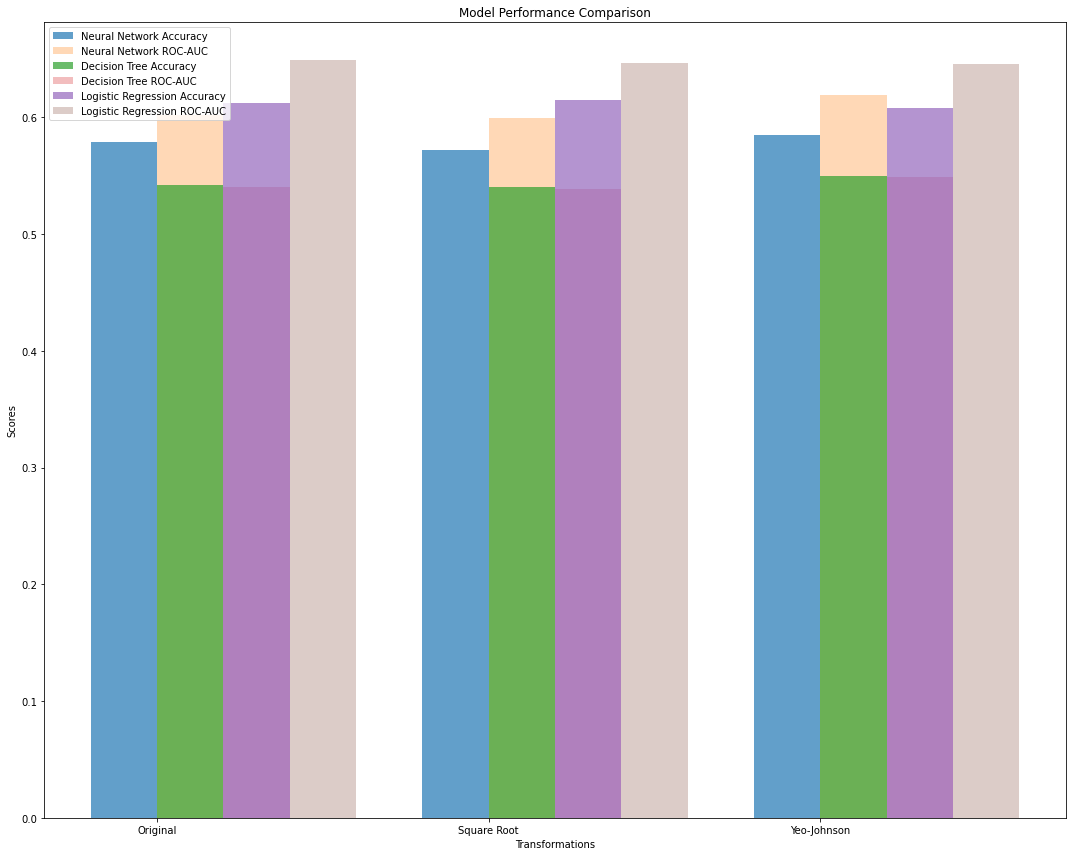

In [10]:
# Extract model names and transformation names dynamically from the results
models = list(all_results.keys())
transformations = list(next(iter(all_results.values())).keys())  # Assumes all models have the same transformations

# Set up a plot
fig, ax = plt.subplots(figsize=(15, 12))

# Create bar positions for transformations
x = np.arange(len(transformations))

# Define the width of the bars
width = 0.2

# Plot the data for each model
for i, model_name in enumerate(models):
    accuracy = [all_results[model_name][transformation]['accuracy'] for transformation in transformations]
    roc_auc = [all_results[model_name][transformation]['roc_auc'] for transformation in transformations]
    
    # Plot bars for accuracy
    ax.bar(x + i * width - width / 2, accuracy, width, label=f'{model_name} Accuracy', alpha=0.7)

    # Plot bars for ROC-AUC
    ax.bar(x + i * width + width / 2, roc_auc, width, label=f'{model_name} ROC-AUC', alpha=0.3)

# Labeling and formatting the chart
ax.set_xlabel('Transformations')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(transformations)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


<span style="font-size: 14px;">Based on the output, transformation didn't improve any of the model's accuracy. And by only <span style="font-size: 14px;">comparing the models, Logistic Regresson shows higher level of accuracy and ROC-AUC.